In [25]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy
from scipy import fftpack

In [26]:
image_file = fits.open('file:///C:/cygwin64/home/rehg98/WLconv_z1100.00_0580r.fits')
image_file.info()
type(image_file)

Filename: C:\Users\rehg98\.astropy\cache\download\py3\1c6f961384c074b1b25de6c1f4fd2344
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       7   (2048, 2048)   float32   


astropy.io.fits.hdu.hdulist.HDUList

In [27]:
image_data = image_file[0].data
image_data = image_data.astype(float)
print(image_data)

[[ 0.28772882  0.31463188  0.31120118 ..., -0.26744589 -0.26138833
  -0.19891326]
 [ 0.23843557  0.26356095  0.27608296 ..., -0.10312956 -0.11086034
  -0.06235358]
 [ 0.32085782  0.3036944   0.35584533 ..., -0.12078809 -0.05707451
  -0.07544205]
 ..., 
 [ 0.30768567  0.30357176  0.30380633 ..., -0.19853105 -0.15406299
  -0.17564408]
 [ 0.16823567  0.13827965  0.25008214 ..., -0.21506804 -0.12519895
  -0.26080811]
 [ 0.19998959  0.20467333  0.2182963  ..., -0.25283489 -0.12982941
  -0.30584782]]


In [28]:
F = fftpack.fftshift(fftpack.fft2(image_data))
psd2D = np.abs(F)**2

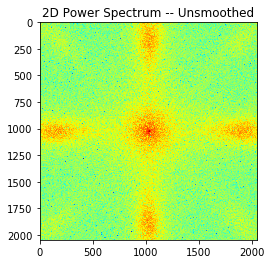

In [29]:
plt.imshow(np.log10(psd2D), cmap=plt.cm.jet)
plt.title("2D Power Spectrum -- Unsmoothed")
plt.show()

In [30]:
smooth_data = scipy.ndimage.filters.gaussian_filter(image_data, 100)
F_smooth = fftpack.fftshift(fftpack.fft2(smooth_data))
psd2D_smooth = np.abs(F_smooth)**2

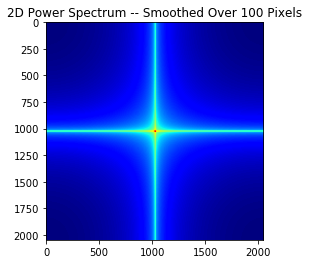

In [31]:
plt.imshow(np.log10(psd2D_smooth), cmap=plt.cm.jet)
plt.title("2D Power Spectrum -- Smoothed Over 100 Pixels")
plt.show()